<h2 align=left> Fine-Tune BERT for Text Classification with TensorFlow and TF-Hub</h2>





<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 1: BERT Classification Model</p>
</div>

The pretrained BERT model used in this project is [available](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) on TensorFlow Hub

# 1. Setup your TensorFlow and Colab Runtime.

In [1]:
!nvidia-smi

Sun May  1 13:06:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install TensorFlow and TensorFlow Model Garden

In [2]:
!pip install -q tensorflow==2.8.0
!pip install -q matplotlib==3.1.1
!pip install -q imgaug==0.2.6

In [3]:
!git clone --depth 1 -b v2.8.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [4]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt

# 2. Download and Import the Quora Insincere Questions Dataset

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [6]:
print("Numpy Version: ", np.__version__)
print("Pandas Version: ", pd.__version__)
print("Tensorflow Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Numpy Version:  1.21.6
Pandas Version:  1.3.5
Tensorflow Version:  2.8.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

In [7]:
df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip',
                 compression='zip', low_memory =False)
df.shape

(1306122, 3)

In [8]:
df.tail(10)

,qid,question_text,target
1306112,ffffa5b0fa76431c063f,Are you ashamed of being an Indian?,1
1306113,ffffae5dbda3dc9e9771,What are the methods to determine fossil ages ...,0
1306114,ffffba7c4888798571c1,What is your story today?,0
1306115,ffffc0c7158658a06fd9,How do I consume 150 gms protein daily both ve...,0
1306116,ffffc404da586ac5a08f,What are the good career options for a msc che...,0
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0
1306121,ffffed09fedb5088744a,Who wins in a battle between a Wolverine and a...,0


In [9]:
print(df.target.value_counts())

0    1225312
1      80810
Name: target, dtype: int64


# 3. Create tf.data.Datasets for Training and Evaluation

In [10]:
#Since dataset suffers from class imbalance problem, stratified sampling is required
train_df, remaining = train_test_split(df, 
                                       random_state=42, 
                                       train_size=0.0075, 
                                       stratify=df.target.values) 

valid_df, _ = train_test_split(remaining, 
                              random_state=42, 
                              train_size=0.00075, 
                              stratify=remaining.target.values)

train_df.shape, valid_df.shape                            

((9795, 3), (972, 3))

In [11]:
#create tf data set for training and validating
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'].values,
                                            train_df['target'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df['question_text'].values,
                                            valid_df['target'].values))
  
  for text, label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


# 4. Download a Pre-trained BERT Model from TensorFlow Hub

In [12]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

 # Label categories
label_list=[0,1]
# maximum length of (token) input sequences
max_seq_length=128
train_batch_size=32

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2',
                          trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file,do_lower_case)

In [13]:
tokenizer.wordpiece_tokenizer.tokenize('I hope this project is useful, doable!')

['[UNK]',
 'hope',
 'this',
 'project',
 'is',
 'useful',
 '##,',
 'do',
 '##able',
 '##!']

In [14]:
#convert token to token ID
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('I hope this project is useful, doable!'))

[100, 3246, 2023, 2622, 2003, 6179, 29623, 2079, 3085, 29612]

# 5. Tokenize and Preprocess Text for BERT

In [15]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid = None,
                                            text_a = text.numpy(), 
                                            text_b = None, 
                                            label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list,
                                    max_seq_length, tokenizer)
  
  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

# 6. Wrap a Python Function into a TensorFlow op for Eager Execution

In [16]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label], 
                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])

  # py_func doesn't set the shape of the returned tensors.
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
  return (x, label_id)

# 7. Create a TensorFlow Input Pipeline with `tf.data`

In [17]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          #.cache()
                          .shuffle(1000)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE)) 

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [18]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [19]:
# valid data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

# 8. Add a Classification Head to the BERT Layer

In [20]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), 
                                       dtype=tf.int32,
                                       name='input_word_ids')
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,),
                                   dtype=tf.int32,
                                   name='input_mask')
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), 
                                   dtype=tf.int32,
                                   name='input_type_ids')
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(drop)
  model = tf.keras.Model(
      inputs={
          'input_word_ids':input_word_ids,
          'input_mask': input_mask,
          'input_type_ids': input_type_ids
      },
      outputs=output
  )
  return model 

# 9. Fine-Tune BERT for Text Classification

In [21]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 128, 768)]                'input_mask[0][0]',         

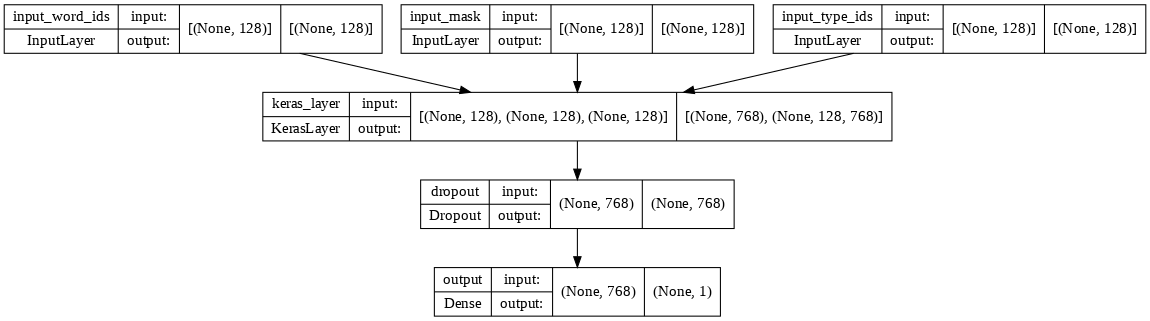

In [22]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

In [23]:
# Train model
epochs=4
history = model.fit(train_data,
                  validation_data= valid_data,
                  epochs=epochs)

Epoch 1/4
306/306 [==============================] - 501s 2s/step - loss: 0.1610 - binary_accuracy: 0.9434 - val_loss: 0.1222 - val_binary_accuracy: 0.9542
Epoch 2/4
306/306 [==============================] - 485s 2s/step - loss: 0.0941 - binary_accuracy: 0.9640 - val_loss: 0.1226 - val_binary_accuracy: 0.9573
Epoch 3/4
306/306 [==============================] - 490s 2s/step - loss: 0.0429 - binary_accuracy: 0.9847 - val_loss: 0.1763 - val_binary_accuracy: 0.9563
Epoch 4/4
306/306 [==============================] - 488s 2s/step - loss: 0.0159 - binary_accuracy: 0.9943 - val_loss: 0.2236 - val_binary_accuracy: 0.9438


# 10. Evaluate the BERT Text Classification Model

In [36]:
history.history

{'binary_accuracy': [0.9434232115745544,
  0.9639501571655273,
  0.9846813678741455,
  0.9942810535430908],
 'loss': [0.1609739363193512,
  0.09406372159719467,
  0.042943358421325684,
  0.015901874750852585],
 'val_binary_accuracy': [0.9541666507720947,
  0.9572916626930237,
  0.956250011920929,
  0.9437500238418579],
 'val_loss': [0.12219515442848206,
  0.12256186455488205,
  0.17634552717208862,
  0.22363807260990143]}

In [45]:
metrics = pd.DataFrame.from_dict(history.history)
metrics = metrics[['binary_accuracy', 'val_binary_accuracy', 'loss', 'val_loss']]
metrics

,binary_accuracy,val_binary_accuracy,loss,val_loss
0,0.943423,0.954167,0.160974,0.122195
1,0.963950,0.957292,0.094064,0.122562
2,0.984681,0.956250,0.042943,0.176346
3,0.994281,0.943750,0.015902,0.223638


In [28]:
sample_example = ["Are Americans Idiots?",\
                  "Why are Indians Brown?",\
                  "Is trump retarded?",\
                  "Why is United Kingdom is the worst place?",\
                  "Why is Messi the GOAT?",
                  ]
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)
preds

array([[9.9818879e-01],
       [9.9786890e-01],
       [9.9777180e-01],
       [3.6149612e-04],
       [9.4481224e-01]], dtype=float32)

In [29]:
['Toxic' if pred >=0.5 else 'Sincere' for pred in preds]

['Toxic', 'Toxic', 'Toxic', 'Sincere', 'Toxic']